<a href="https://colab.research.google.com/github/BehnoodRasti/SparseEDAA/blob/main/SparseEDAA_Alex_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
#!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git
#!git clone https://github.com/BehnoodRasti/SUnCNN.git

In [99]:
#!pip install munkres

In [3]:
import time
import os

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import numpy.linalg as LA
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm

from munkres import Munkres
#from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
#from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
#from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
#from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SAD 
#from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner
from IPython.display import clear_output
import sys

In [5]:
import scipy.io
import numpy as np
fname2  = "Y_clean.mat"
mat2 = scipy.io.loadmat(fname2)
img_np_gt = mat2["Y_clean"]
img_np_gt = img_np_gt.transpose(2,0,1)
[p1, nr1, nc1] = img_np_gt.shape
img_resh=np.reshape(img_np_gt,(p1,nr1*nc1))
#%%
fname3  = "XT.mat"
mat3 = scipy.io.loadmat(fname3)
A_true_np = mat3["XT"]

#%%
fname4  = "EE.mat"
mat4 = scipy.io.loadmat(fname4)
EE = mat4["EE"]
D=EE
#%%
p = 5 # number of endmembers

In [6]:
#LA.norm(img_resh, axis=0, ord=2, keepdims=True)

In [7]:
Y = img_resh

In [8]:
L, N = Y.shape

In [9]:
# indices = np.random.choice(np.arange(N), size=100)

In [10]:
# plt.plot(img_resh[:, indices]);

In [11]:
# Y = Y / LA.norm(Y, axis=0, ord=2, keepdims=True)
# plt.plot(Y[:, indices]);

In [12]:
# !pip install cvxpylayers

In [13]:
# import cvxpy as cp
# import torch
# from cvxpylayers.torch import CvxpyLayer

# p, N = 4, 100
# LibS=220
# x = cp.Variable((p,N))
# AA = cp.Parameter((LibS, p))
# bb = cp.Parameter((LibS,N))
# onesp=torch.ones((p,1))#.to(self.device) 
# onesn=torch.ones((N,1))#.to(self.device) 
# constraints = [onesp.t()@x == onesn.t()]
# objective = cp.Minimize(0.5 * cp.pnorm((AA @ x - bb)**2, p=2))
# problem = cp.Problem(objective, constraints)
# assert problem.is_dpp()

# cvxpylayer = CvxpyLayer(problem, parameters=[AA, bb], variables=[x])
# A_tch = torch.randn(LibS, p, requires_grad=True)
# b_tch = torch.randn(LibS,N, requires_grad=True)

# # solve the problem
# solution, = cvxpylayer(A_tch, b_tch,'ignore_dpp = True')
# print(solution)
# # compute the gradient of the sum of the solution with respect to A, b
# solution.sum().backward()

In [14]:
class SparseEDAA:
    def __init__(self,lamb=0.1, mu1=20,mu2=10,mu3=1, TA=5, TB=10,T=20000):
        self.mu1 = mu1
        self.mu2 = mu2
        self.mu3 = mu3
        self.TA = TA
        self.TB = TB
        self.T =T
        self.lamb=lamb
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def solve(
        self,
        Y,
        D,
        p,
        seed=0,
        **kwargs,
    ):
        
        L, N = Y.shape
        LibS=D.shape[1]
        def residual(a, b):
            return 0.5 * ((Y - (D @ b) @ a) ** 2).sum()

        def lossTot(a, b, lamb):
            return residual(a, b) + lamb * b.abs().sum()
        results = {}
        #eps=sys.float_info.epsilon
        tic = time.time()

        #for m in tqdm(range(self.M)):
        #    torch.manual_seed(m + seed)
        #    generator = np.random.RandomState(m + seed)
        #    with torch.no_grad():
        A = (1 / p) * torch.ones((p, N))
        B=(1 / LibS) * torch.ones((LibS, p))
        L1 = torch.zeros((p,N))
        L2 = torch.zeros((LibS,p))
        L3 = torch.zeros((L,p))
        S1=L1
        S2=L2
        S3=L3
        inv1=torch.zeros((p,p))
        inv2=torch.zeros((1,1))
        inv3=torch.zeros((LibS,LibS))
        inv4=inv2
        # Send matrices on GPU
        D = D.to(self.device)
        Y = Y.to(self.device)
        A = A.to(self.device)
        B = B.to(self.device)
        S1 = S1.to(self.device)
        S2 = S2.to(self.device)
        S3 = S3.to(self.device)
        L1 = L1.to(self.device)
        L2 = L2.to(self.device)
        L3 = L3.to(self.device)
        eyep=torch.eye(p).to(self.device) 
        eyeLibS=torch.eye(LibS).to(self.device) 
        onesp=torch.ones((p,1)).to(self.device) 
        onesLibS=torch.ones((LibS,1)).to(self.device) 
        onesn=torch.ones((N,1)).to(self.device) 
        eyeL=torch.eye(L).to(self.device) 
        # Random Step size factor
        DtY=D.t()@Y
        inv3=torch.inverse(self.mu3*D.t()@D+self.mu2*eyeLibS)#+eyeLibS*eps)
        inv4=-1/(onesLibS.t()@inv3@onesLibS)
        inv5=torch.inverse(self.mu2*eyeLibS+self.mu3*D.t()@D)
        soft=torch.nn.Softshrink(self.lamb/self.mu2)
        hard=torch.nn.Hardshrink(np.sqrt(2*self.lamb/self.mu2))
        for ii in tqdm(range(self.T)):
            for jj in range(self.TA):
                inv1=torch.inverse(self.mu3*S3.t()@S3+self.mu1*eyep)
                inv2=-1/(onesp.t()@inv1@onesp)
                A=(inv1+inv1@onesp@inv2@onesp.t()@inv1)@(S3.t()@Y+self.mu1*(S1-L1))-inv1@onesp@(inv2*onesn.t())
                S1= (A+L1)
                S1[S1<=0]=0
                L1 = L1 + A - S1
                #print(lossTot(A,B,self.lamb).item())
            for jj in range(self.TB):
                #B=(inv3+inv3@onesLibS@inv4@onesLibS.t()@inv3)@(mu3*D.t()@(S3-L3)+mu2*(S2-L2))-inv3@onesLibS@(inv4*onesp.t())
                B=inv5@(self.mu2*(S2-L2)+self.mu3*D.t()@(S3-L3))
                #S2= (B+L2)
                #============
                S2= hard(B+L2)
                S2[S2<=0]=0
                #===========
                S2[S2>=1]=1
                #=========== 
                L2 = L2 + B - S2
                S3=(Y@A.t() + self.mu3*(D@B+L3))@torch.inverse(A@A.t()+self.mu3*eyep)
                L3 = L3 + D@B - S3
                print(lossTot(A,B, self.lamb).item())
                # inv1=torch.inverse(self.mu3*S3.t()@S3+self.mu1*eyep)
                # inv2=-1/(onesp.t()@inv1@onesp)
                # A=(inv1+inv1@onesp@inv2@onesp.t()@inv1)@(S3.t()@Y+self.mu1*(S1-L1))-inv1@onesp@(inv2*onesn.t())
                # B=(inv3+inv3@onesLibS@inv4@onesLibS.t()@inv3)@(self.mu3*D.t()@(S3-L3)+self.mu2*(S2-L2))-inv3@onesLibS@(inv4*onesp.t())
                # S3=(Y@A.t() + self.mu3*(D@B+L3))@torch.inverse(A@A.t()+self.mu3*eyep)
                # S1= (A+L1)
                # S1[S1<=0]=0
                # S2= (B+L2)
                # S2[S2<=0]=0
                # L1 = L1 + A - S1
                # L2 = L2 + B - S2
                # L3 = L3 + D@B - S3
            #print(lossTot(A,B,self.lamb).item())
            if ii % 10 == 0:
                    clear_output(wait=False)
        E = (D @ B).cpu().numpy()
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        # Store results
        results[1] = {
            "Em": E,
            "Am": A,
            "Bm": B,
        }

        toc = time.time()
        elapsed_time = round(toc - tic, 2)
        print(f"{self} took {elapsed_time}s")

        return E,B, A

    def __repr__(self):
        msg = f"{self.__class__.__name__}"
        return msg

In [15]:
import numpy as np


class AdditiveWhiteGaussianNoise:
    def __init__(self):
        self.sigmas = None
        self.SNR = None
        self.L = None
        self.N = None

    def fit(self, Y, SNR: float):
        """
        Compute sigmas at the desired SNR given a flattened input HSI Y
        """
        assert len(Y.shape) == 2
        self.L, self.N = Y.shape
        #logger.debug(f"Y shape: {Y.shape}")
        self.SNR = SNR
        #logger.debug(f"Desired SNR: {self.SNR}")

        if SNR is None:
            self.sigmas = np.zeros(self.L)
        else:
            assert SNR > 0, "SNR must be stricly positive"
            # Uniform across bands
            sigmas = np.ones(self.L)
            # Normalization
            sigmas /= np.linalg.norm(sigmas)
            #logger.debug(f"Sigmas after normalization: {sigmas[0]}")
            # compute mean sigma
            num = np.sum(Y ** 2) / self.N
            denom = 10 ** (self.SNR / 10)
            sigmas_mean = np.sqrt(num / denom)
            #logger.debug(f"Sigma mean based on SNR: {sigmas_mean}")
            # Noise variance
            sigmas *= sigmas_mean
            #logger.debug(f"Final sigmas value: {sigmas[0]}")
            self.sigmas = sigmas

    def transform(self, Y, seed=0):
        """
        Add White Gaussian Noise to the flattened input HSI Y
        """
        assert self.sigmas is not None, "Must be fitted first"
        assert (self.L, self.N) == Y.shape
        # Fix random seed
        generator = np.random.RandomState(seed=seed)
        # Noise generation
        N = np.diag(self.sigmas) @ generator.randn(self.L, self.N)
        # Additive Noise
        return Y + N

    def fit_transform(self, Y, SNR, seed=0):
        """
        Combine `fit` and `transform` methods.
        See above for their respective usage.
        """
        self.fit(Y, SNR)
        return self.transform(Y, seed=seed)

In [16]:
# # Subspace Setup
# from scipy import linalg
# model = SparseEDAA(K1=1, K2=1, T=20000, M=1)
# #Y = img_resh
# D=EE
# #img_mean=np.mean(img_resh,1).reshape(p1,1)
# #img_mean_rmv=img_resh-img_mean
# #V, SS, U = scipy.linalg.svd(img_mean_rmv@img_mean_rmv.transpose(1,0)/(nr1*nc1), full_matrices=False)
# #Y=V[:,:p].transpose(1,0)@img_mean_rmv
# Y = noise.fit_transform(img_resh, SNR=40, seed=0)
# V, SS, U = scipy.linalg.svd(Y, full_matrices=False)
# Y_r=V[:,:p].transpose(1,0)@Y
# DD = V[:,:p].transpose(1,0)@D
# noise = AdditiveWhiteGaussianNoise()
# Y_r = torch.Tensor(Y_r)
# DD = torch.Tensor(DD)
# D = torch.Tensor(D)
# E00, A0 = model.solve(Y_r, DD, p, seed=1)
# E0=V[:,:p]@E00

In [25]:
# Instantiate objects
model = SparseEDAA(lamb=0.5, mu1=30,mu2=20,mu3=1, TA=10,TB=10,T=2000)
Y = img_resh
D = EE#np.concatenate((EE, Y), axis=1)
noise = AdditiveWhiteGaussianNoise()
Y = noise.fit_transform(Y, SNR=40, seed=0)
from scipy import linalg
V, SS, U = scipy.linalg.svd(Y, full_matrices=False)
PC=np.diag(SS)@U
Y_DN=V[:,:p]@PC[:p,:]
# Convert the data to tensors
Y = torch.Tensor(Y)
Y_DN = torch.Tensor(Y_DN)
D = torch.Tensor(D)
# Abundances estimation
E0,B0, A0 = model.solve(Y_DN, D, p, seed=1)

2.716306686401367
2.7162423133850098
2.716257095336914
2.7163314819335938
2.716238021850586
2.716277837753296
2.7162816524505615
2.7162585258483887
2.7162933349609375
2.7162437438964844
2.7162790298461914
2.716304302215576
2.7162678241729736
2.716315984725952
2.716264009475708
2.7162821292877197
2.7163119316101074
2.7162294387817383
2.7162973880767822
2.716352939605713
2.7162740230560303
2.7163026332855225
2.716264009475708
2.716245651245117
2.7162623405456543
2.716273784637451
2.7163500785827637
2.7162563800811768
2.716259479522705
2.716294050216675
2.716273784637451
2.716296672821045
2.716238260269165
2.716308355331421
2.716261863708496
2.7162485122680664
2.7163100242614746


100%|█████████████████████████████████████████████████▉| 1995/2000 [00:30<00:00, 64.77it/s]

2.716280937194824
2.7162396907806396
2.716264247894287
2.7162692546844482
2.716277837753296
2.716270685195923
2.716261386871338
2.716275691986084
2.7162580490112305
2.7162728309631348
2.716291666030884
2.7162489891052246
2.7162489891052246
2.716270923614502
2.7163758277893066
2.7162396907806396
2.7162671089172363
2.7162842750549316
2.716268539428711
2.71626353263855
2.7162725925445557
2.7162559032440186
2.7163400650024414
2.716266632080078
2.716251850128174
2.7162513732910156
2.716273784637451
2.716278314590454
2.716254711151123
2.7162461280822754
2.7162976264953613
2.7162439823150635
2.716254234313965
2.7162930965423584
2.7162492275238037
2.716282844543457
2.7163310050964355
2.7162623405456543
2.7162327766418457
2.7162814140319824
2.7163209915161133
2.716277599334717
2.7162299156188965
2.71624493598938
2.7162671089172363
2.716273307800293
2.7162320613861084
2.7162539958953857


100%|██████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 64.49it/s]

2.7162508964538574
2.7162673473358154
2.716233253479004
2.7162725925445557
2.716245174407959
SparseEDAA took 31.06s


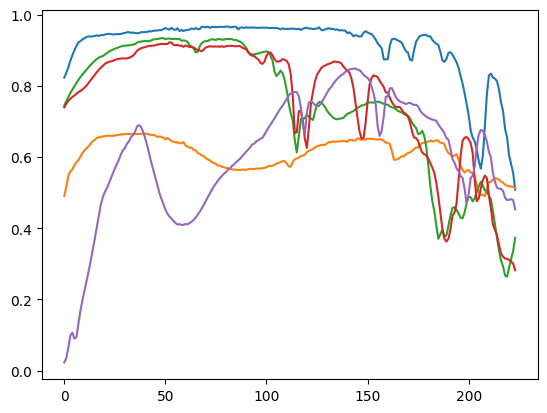

In [26]:
plt.plot(E0)

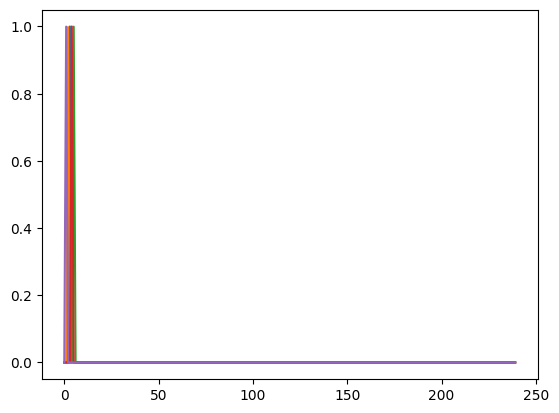

In [27]:
plt.plot(B0)

In [28]:
# Select a criterion to perform alignment
#criterion = MSE()

# Select an aligner to perform alignment
A_true = A_true_np.reshape((EE.shape[1],nr1*nc1))#[1:p+1,:]
#aligner = MunkresAbundancesAligner2(A=A_true, criterion=criterion)

#A1 = aligner.fit_transform(A0)
#E1 = aligner.transform_endmembers(E0)

#
#x = A0.astype(np.float32).reshape((EE.shape[1],nr1*nc1))
SRE = 20*np.log10(LA.norm(A_true,'fro')/LA.norm((A_true - B0@A0),'fro'))

print ('SRE: %f' % (SRE))





SRE: 31.468481


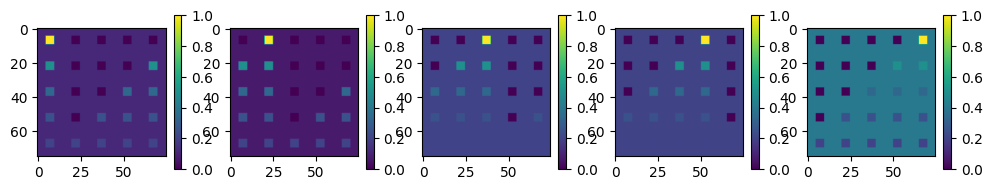

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 4))
A_reshape = A_true[1:p+1,:].reshape((p, nr1, nc1))
for kk in range(p):
    curr_ax = ax[kk]
    mappable = curr_ax.imshow(A_reshape[kk], vmin=0.0, vmax=1.0)
    fig.colorbar(mappable, ax=curr_ax, shrink=0.5)

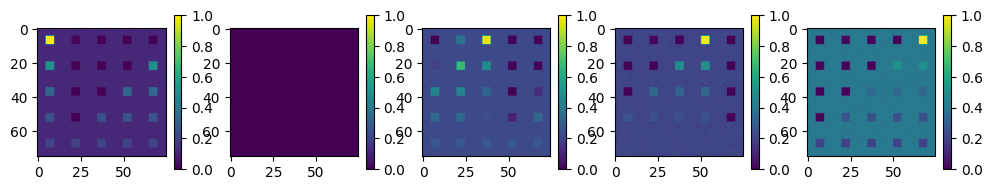

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 4))
A2 = (B0@A0)[1:p+1,:].reshape((p, nr1, nc1))
for kk in range(p):
    curr_ax = ax[kk]
    mappable = curr_ax.imshow(A2[kk], vmin=0.0, vmax=1.0)
    fig.colorbar(mappable, ax=curr_ax, shrink=0.5)